In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import scarches as sca
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
from velovi import VELOVI

In [ ]:
#Choose dataset
dataset = "pbmc"

#Choose model to train
model = "ivelo"

In [ ]:
adata_output = "data/" + dataset + "/" + dataset + "_data_output.h5ad" #path of output adata after training model
adata = sc.read(adata_output)

In [ ]:
#Load model
vae=VELOVI.load("trained_models/" + dataset + "/" + model, adata)

Latent enrichment

In [ ]:
from itertools import compress
vae.latent_directions(adata=adata)
active_terms_idx=list(compress(np.arange(len(adata.uns["terms"])), vae.nonzero_terms()))
scores_ct = vae.latent_enrich('clusters', use_directions=True, select_terms = active_terms_idx, adata=adata, exact=True)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/cabright61/anaconda3/envs/thesis/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                         

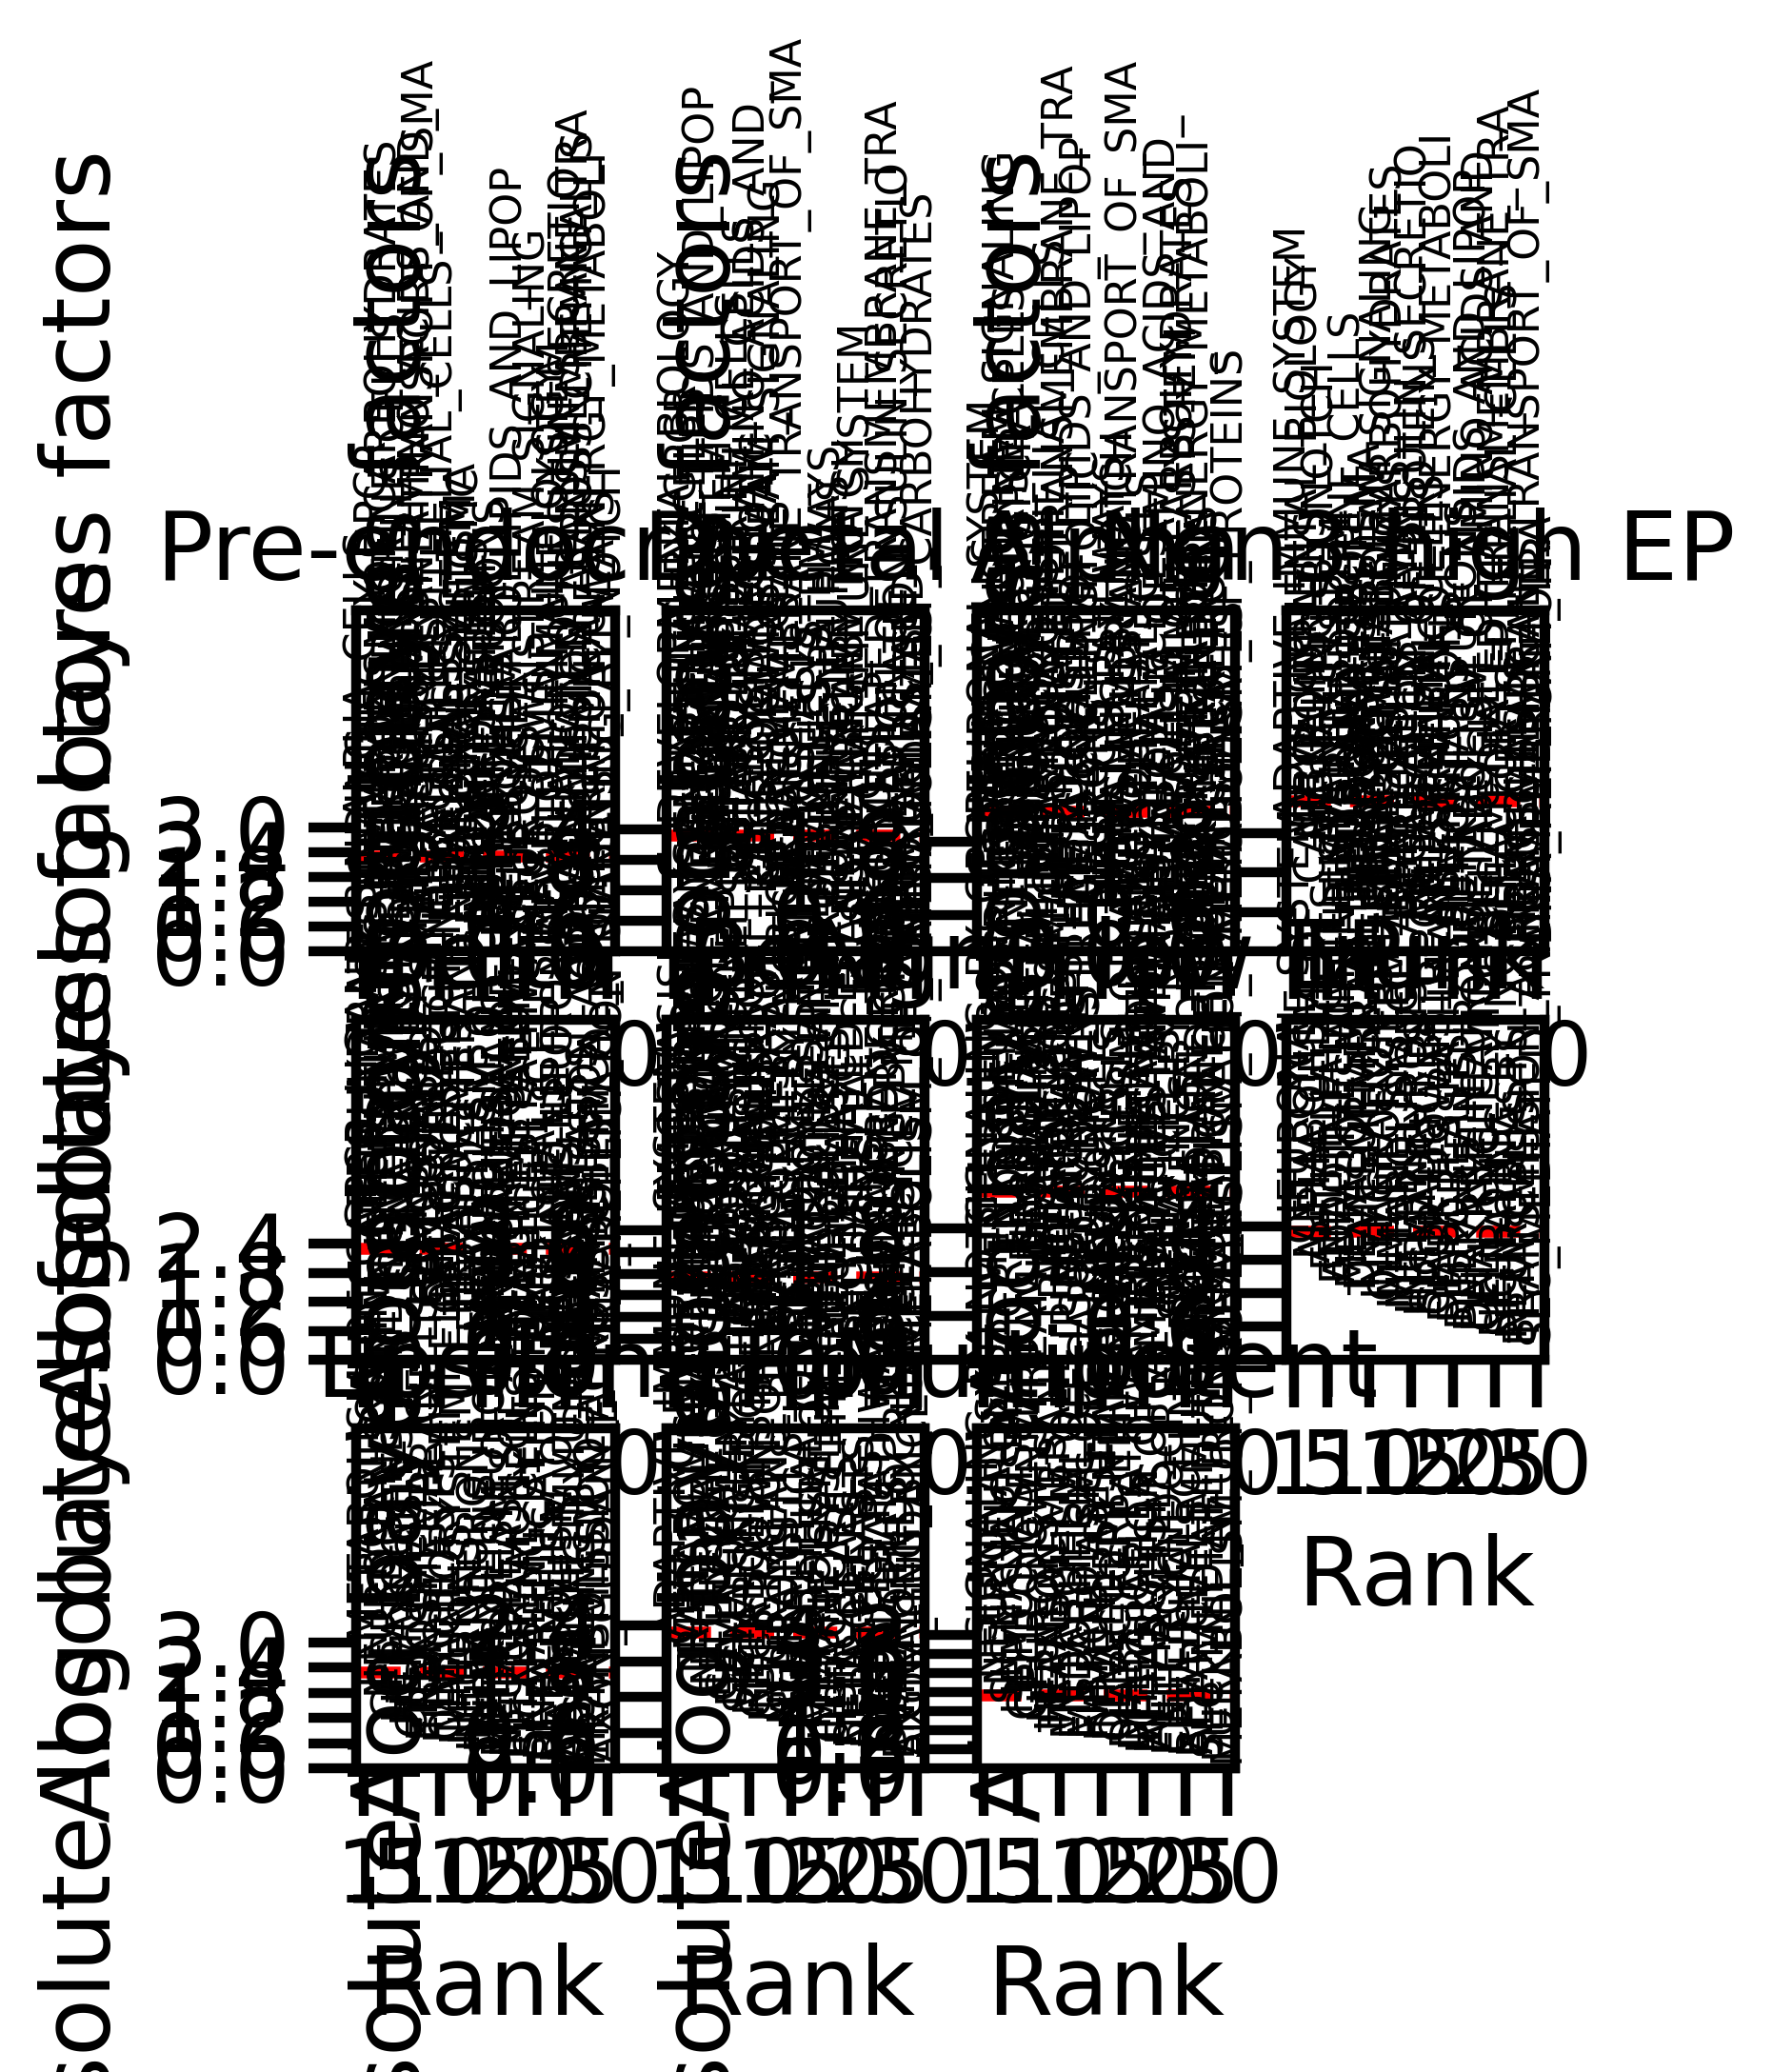

In [ ]:
active_terms=list(compress(adata.uns["terms"], vae.nonzero_terms()))
fig = sca.plotting.plot_abs_bfs(adata, n_cols=4, terms=active_terms, scale_y=2.6, yt_step=0.6)

In [ ]:
fig.set_size_inches(24, 20)
fig

In [ ]:
fig.savefig("figures/" + dataset + "/" + model + "/latent_enrich.png")

### Save latent enrich results to dictionary

In [ ]:
import collections
top_gps_per_cell = collections.defaultdict(dict)
for cell_type in adata.uns["bf_scores"].keys():
    mask=abs(adata.uns["bf_scores"][cell_type]["bf"])>=2.3
    GP_index=np.arange(len(active_terms))
    sig_GP_index=list(compress(GP_index, mask))
    top_gps_per_cell[cell_type]["terms"] = np.array(active_terms)[sig_GP_index]
    top_gps_per_cell[cell_type]["terms"] = np.array(active_terms)[sig_GP_index]
    top_gps_per_cell[cell_type]["bf_scores"] = adata.uns["bf_scores"][cell_type]["bf"]
    top_gps_per_cell[cell_type]["bf_scores_sig"] = adata.uns["bf_scores"][cell_type]["bf"][mask]
    top_gps_per_cell[cell_type]["sig_GP_index"] = sig_GP_index

In [ ]:
import collections

#add active terms and bf_scores into df

top_n_terms=[]
for cell_type in adata.uns["bf_scores"].keys():
    bf_scores=adata.uns["bf_scores"][cell_type]["bf"]
    d = {'active_terms': active_terms, 'bf_scores': bf_scores}
    df=pd.DataFrame(data=d, columns=["active_terms", "bf_scores"])
    top_n_df=df.sort_values(by=["bf_scores"], ascending=False)[:10]
    top_n_terms.append(top_n_df["active_terms"])

top_n_terms = set(top_n_terms) #100

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

acc=[]
idx = [active_terms.index(term) for term in top_n_terms]
directions=adata.uns["directions"]
directions=directions[directions!=0]
latents = (adata.obsm["X_" + model + "_opt_active"]*directions)[:, idx]
labels=pd.Categorical(adata.obs["clusters"]).codes
#for i in range(latents.shape[1]):
#    X_train, X_test, y_train, y_test = train_test_split(latents[:,i].reshape(-1, 1), labels, test_size=.2)
#    clf = GradientBoostingClassifier().fit(latents[:,i].reshape(-1, 1), labels)
#    pred=clf.predict(latents[:,i].reshape(-1, 1))
#    acc.append(clf.score(latents[:,i].reshape(-1, 1), labels))

X_train, X_test, y_train, y_test = train_test_split(latents, labels, test_size=0.2)
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

def fit(x):
    params = {'objective':'multi:softmax',
              'num_class': len(list(set(labels))),
              'max_depth':int(x[0]),
              'learning_rate':x[1]}
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, 
    nfold=5, seed=42)
    return xgb_cv[-1:].values[0]

grid = pd.DataFrame({'max_depth':[3,5,10]*3, 
                     'learning_rate':np.repeat([0.01,0.05,0.1],3),
                     #'subsample':np.repeat([0.1,0.3],3)
                    })

grid[['train-mean','train-std',
'test-mean','test-std']] = grid.apply(fit,axis=1,result_type='expand')


In [1]:
243*4

972

In [ ]:
grid

In [ ]:
clf = XGBClassifier(objective='multi:softmax',
                           learning_rate = 0.1,
                           max_depth = 10)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)
top_gps_per_cell["XGB_acc"] = accuracy

In [ ]:
#save dictionary to pkl
import pickle
with open('output/' + dataset + '/' + model + '/GP_analysis.pkl', 'wb') as f:
    pickle.dump(top_gps_per_cell, f)

Velocity comparison

Compare model to velovi

In [ ]:
#Compute MSE

import pandas as pd
pred=vae.get_expression_fit()
pred_s=pred[0]
pred_u=pred[1]
GT_s=adata.layers["Ms"]
GT_u=adata.layers["Mu"]
MSE_s=np.mean((pred_s-GT_s)**2, axis=0)
MSE_u=np.mean((pred_u-GT_u)**2, axis=0)

MSE=pd.DataFrame([MSE_s,MSE_u]).T

MSE.to_csv("output/" + dataset + "/" + model + "/" + "MSE_.csv")


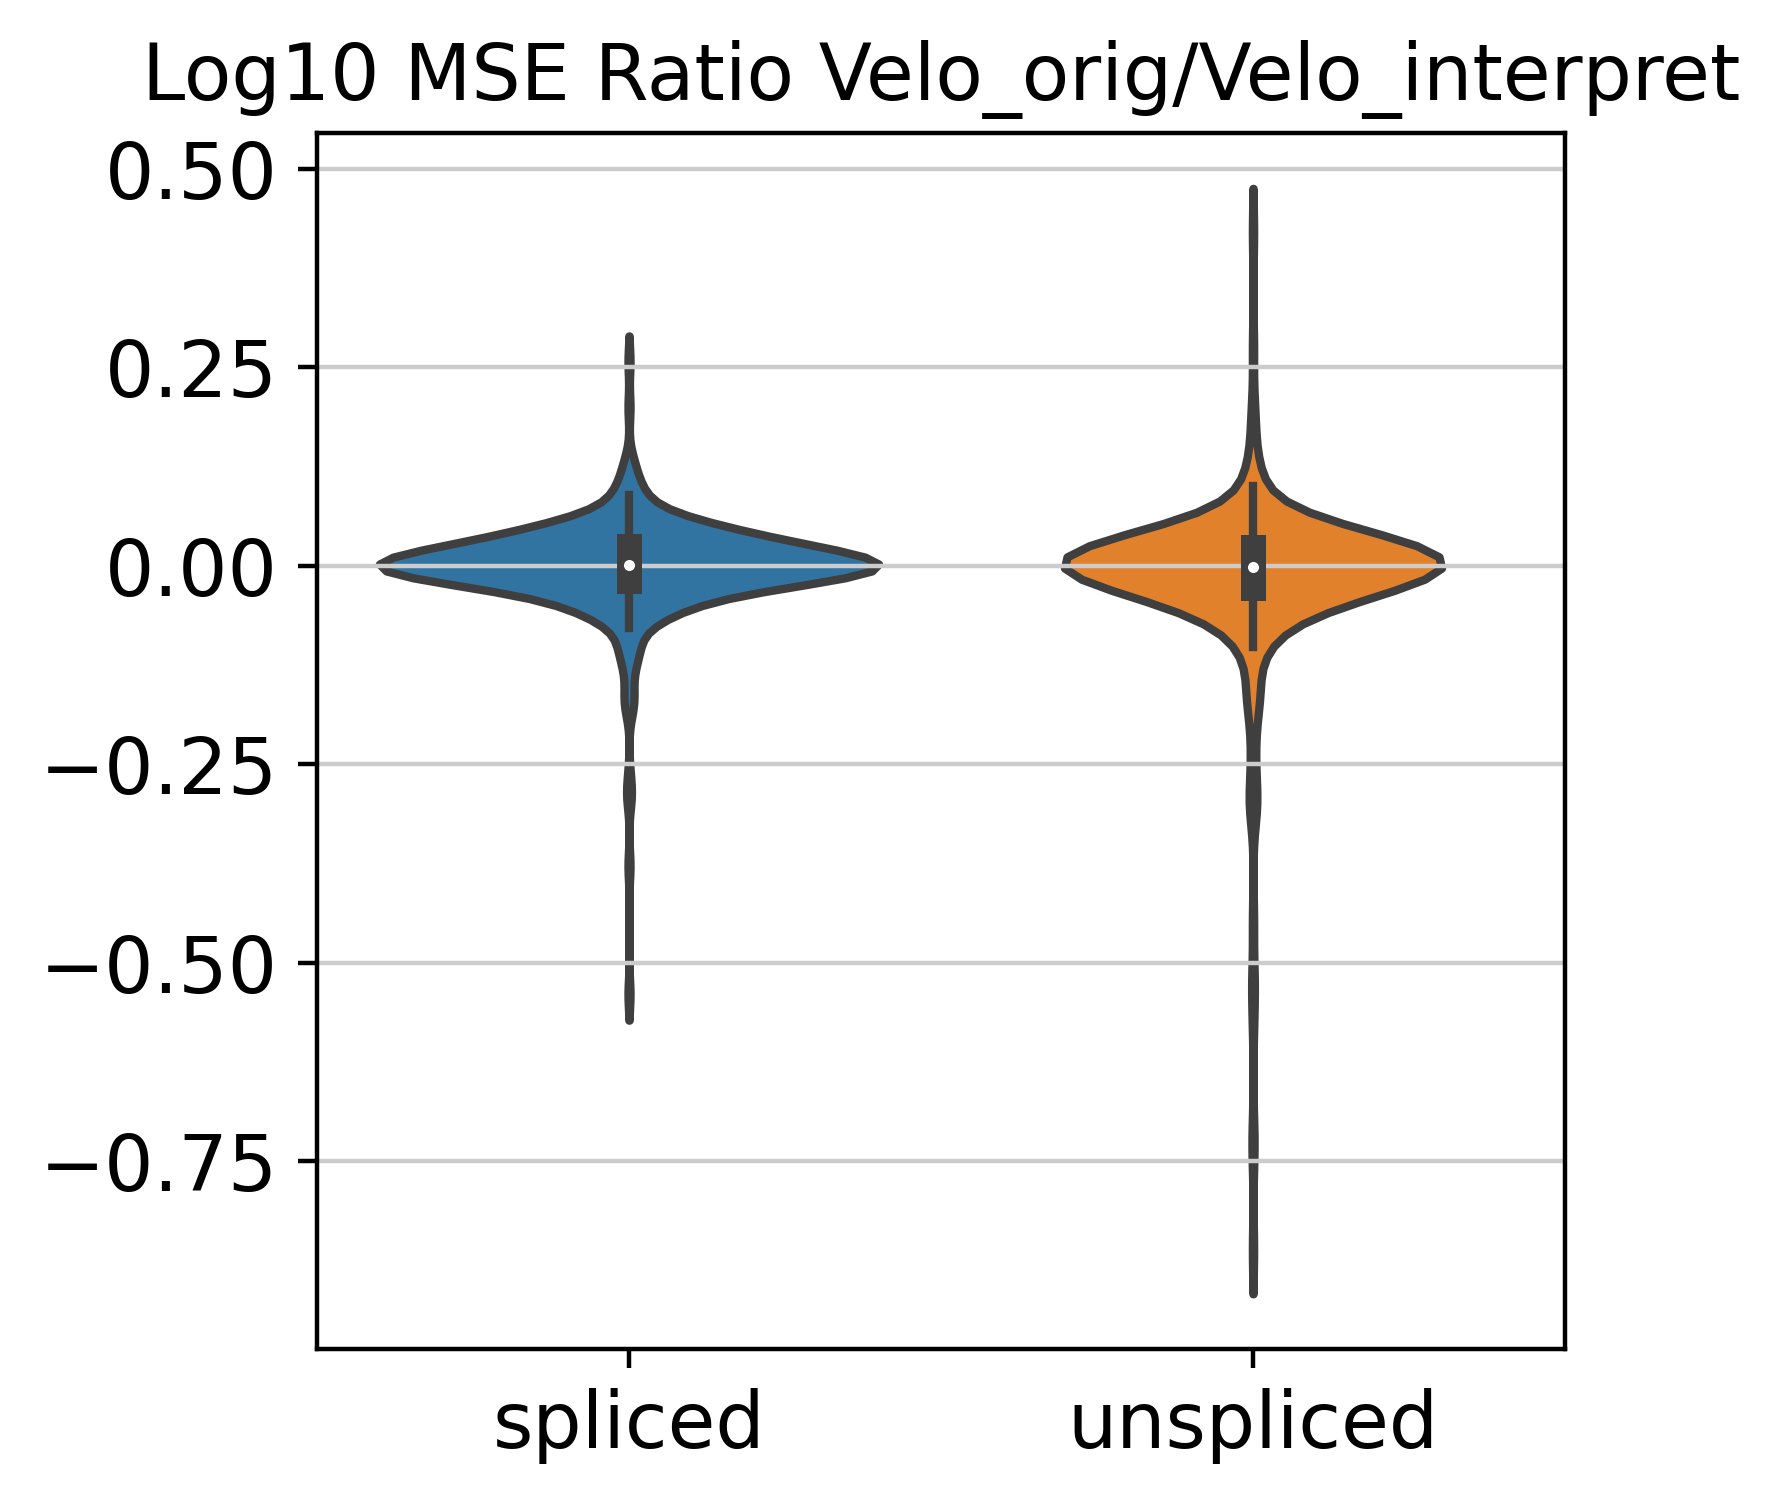

In [ ]:
#Get violin plot of log10 MSEs
ax=sns.violinplot(data=MSE_combined)
ax.set_title("Log10 MSE Ratio Velo_orig/Velo_interpret")
MSE_fig=ax.get_figure()
#MSE_fig.savefig("figures/decoder2/log10MSE.png") 

Add outputs of velo_interpret to adata

In [ ]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [ ]:
#get velocity confidence 
scv.tl.velocity_graph(adata)
scv.tl.velocity_confidence(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [ ]:
#save velocity confidene results
velo_int_s_vc=pd.DataFrame(adata.obs["velocity_confidence"])
velo_int_s_vc.to_csv("vel_conf_Velo_Int_S.csv")

In [ ]:
velo_orig_vc=pd.read_csv("vel_conf_veloVI.csv", index_col="index")
velo_orig_vc=velo_orig_vc.rename(columns={"velocity_confidence":"vc_veloVI"})
scvelo_vc=pd.read_csv("vel_conf_scVelo.csv", index_col="index")
scvelo_vc=scvelo_vc.rename(columns={"velocity_confidence":"vc_scvelo"})
# velo_int_s_vc=pd.read_csv("vel_conf_Velo_Int_S.csv", index_col="index")
# velo_int_s_vc=velo_int_s_vc.rename(columns={"velocity_confidence":"vc_velo_interpret_single"})
velo_int_d_vc=pd.DataFrame(adata.obs["velocity_confidence"])
velo_int_d_vc=velo_int_d_vc.rename(columns={"velocity_confidence":"vc_velo_interpret_single"})

In [ ]:
vc_combined=pd.concat([scvelo_vc,velo_orig_vc,velo_int_d_vc],axis=1)

In [ ]:
vc_combined

vc_scvelo  vc_veloVI  vc_velo_interpret_single
index                                                           
AAACCTGAGAGGGATA   0.769216   0.900101                  0.896680
AAACCTGAGCCTTGAT   0.792310   0.910085                  0.897434
AAACCTGAGGCAATTA   0.733762   0.840806                  0.873588
AAACCTGCATCATCCC   0.746999   0.881598                  0.905368
AAACCTGGTAAGTGGC   0.775375   0.905970                  0.911187
...                     ...        ...                       ...
TTTGTCAAGTGACATA   0.589383   0.853201                  0.861832
TTTGTCAAGTGTGGCA   0.717359   0.838502                  0.834472
TTTGTCAGTTGTTTGG   0.657952   0.858520                  0.820456
TTTGTCATCGAATGCT   0.809008   0.901181                  0.900746
TTTGTCATCTGTTTGT   0.704007   0.833331                  0.858083

[3696 rows x 3 columns]

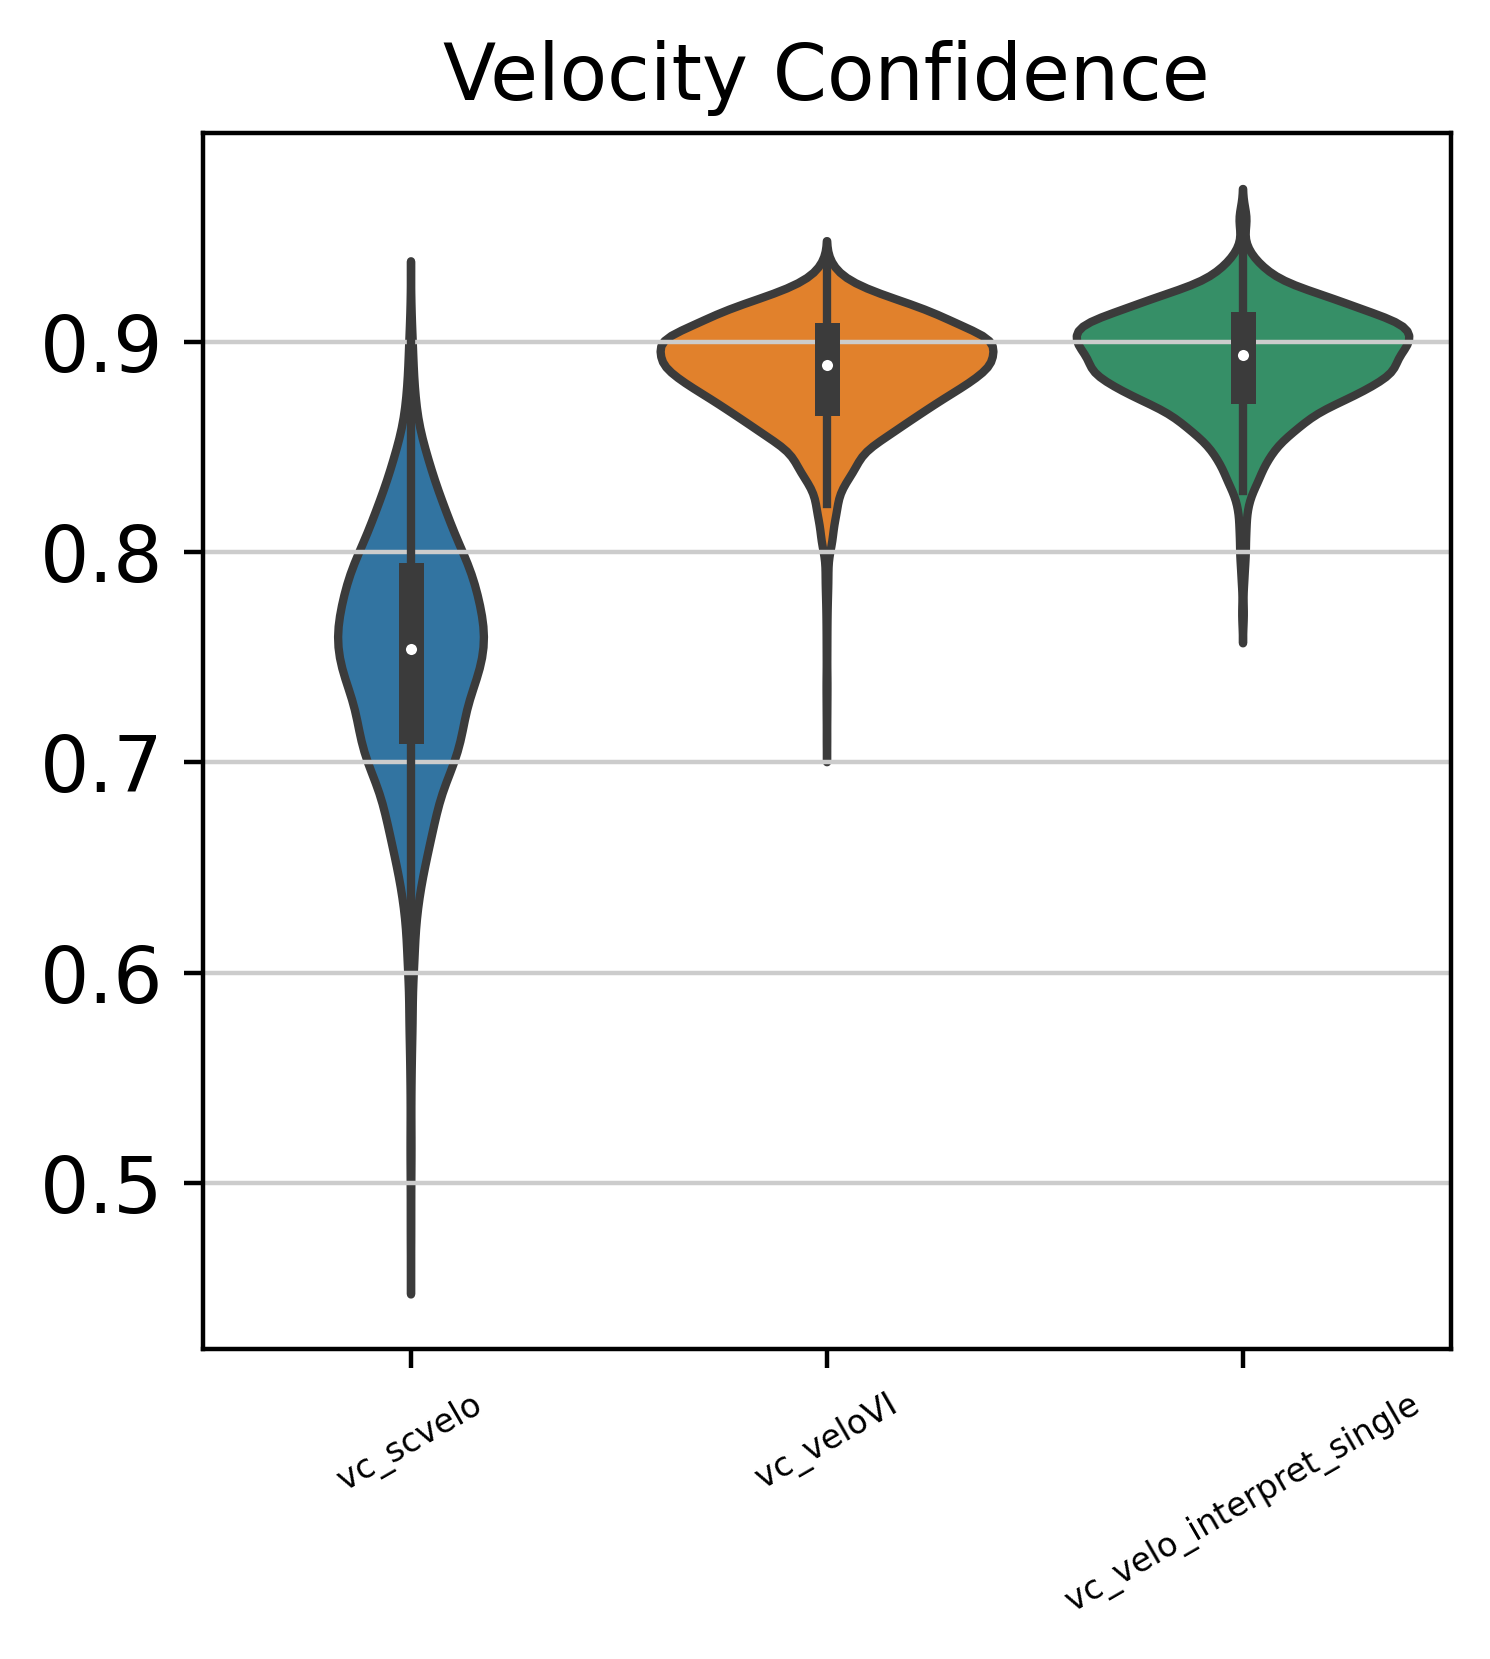

In [ ]:
#Get violin plot of velocity confidence
ax=sns.violinplot(data=vc_combined)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, size = 6)
ax.set_title("Velocity Confidence")
fig=ax.get_figure()
#fig.savefig("figures/vel_conf.png") 

Get Velocity graph

In [ ]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
